In [3]:
pip install opencv-python

     -------------------------------------- 38.2/38.2 MB 896.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth if there is GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
import cv2
import imghdr

In [61]:
data_dir = 'datasets' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
classes = { 0: "Male", 1:"Female"}
classes[1]

'Female'

In [11]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as err: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Load Data

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 11649 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

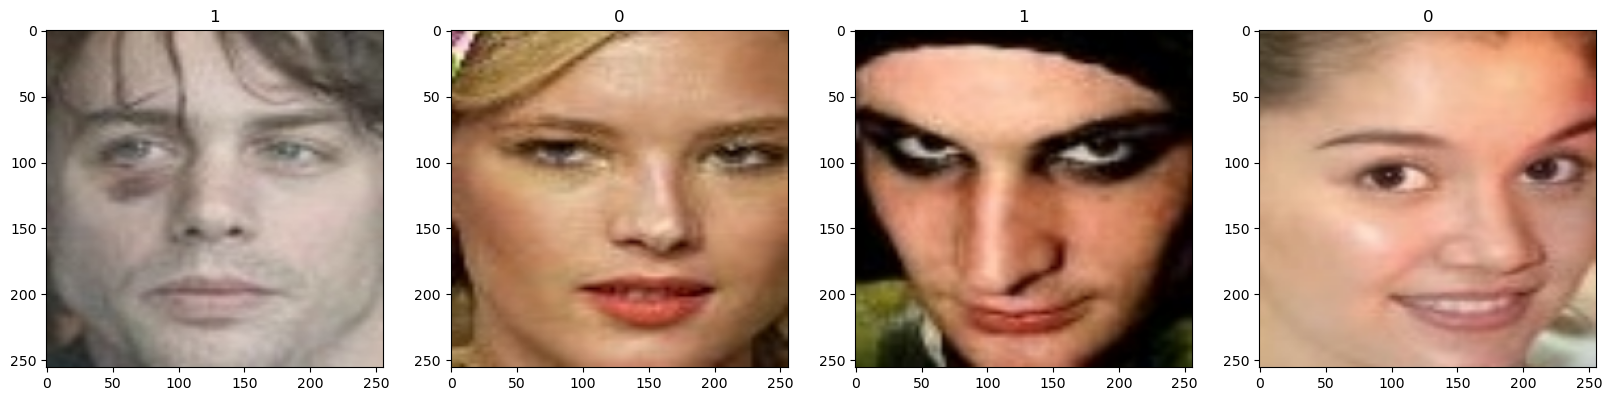

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

## Split Data

In [19]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

In [20]:
train_size

292

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Build Deep Learning Model

In [22]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
292/292 [==============================] - 292s 998ms/step - loss: 0.3597 - accuracy: 0.8491 - val_loss: 0.2866 - val_accuracy: 0.8837
Epoch 2/5
292/292 [==============================] - 296s 1s/step - loss: 0.2375 - accuracy: 0.9073 - val_loss: 0.2040 - val_accuracy: 0.9236
Epoch 3/5
292/292 [==============================] - 292s 998ms/step - loss: 0.1987 - accuracy: 0.9208 - val_loss: 0.1983 - val_accuracy: 0.9227
Epoch 4/5
292/292 [==============================] - 295s 1s/step - loss: 0.1610 - accuracy: 0.9366 - val_loss: 0.1802 - val_accuracy: 0.9271
Epoch 5/5
292/292 [==============================] - 307s 1s/step - loss: 0.1493 - accuracy: 0.9405 - val_loss: 0.1753 - val_accuracy: 0.9262


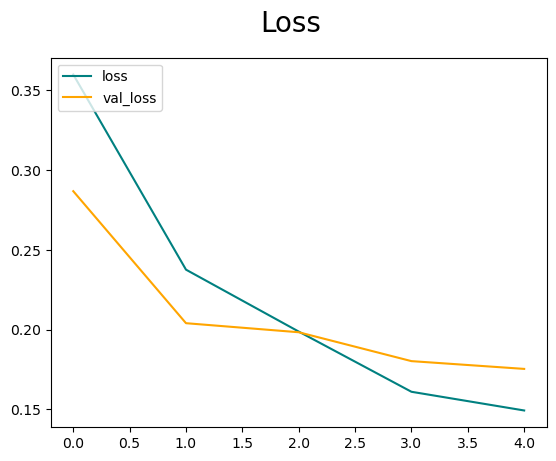

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

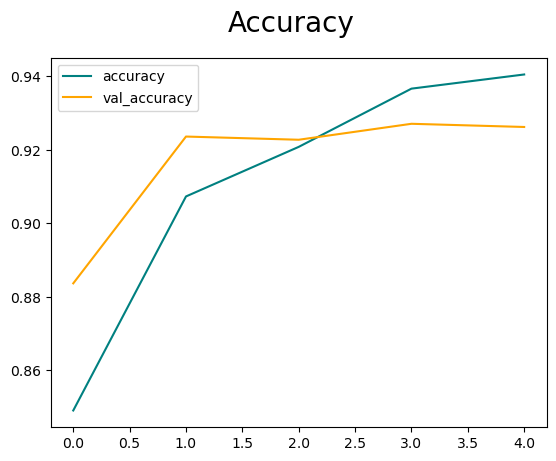

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 308ms/step


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.89782244, shape=(), dtype=float32) tf.Tensor(0.938704, shape=(), dtype=float32) tf.Tensor(0.9166667, shape=(), dtype=float32)


## Test

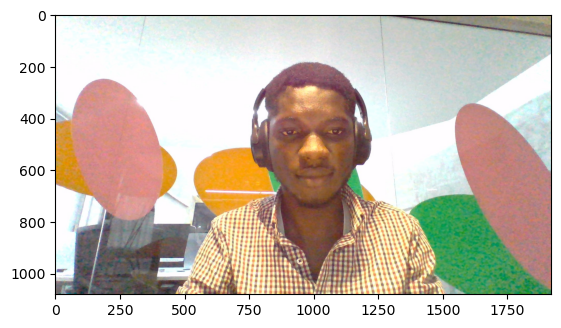

In [49]:
import cv2
img = cv2.imread('C:/Users/JB/Pictures/Camera Roll/WIN_20230502_03_19_12_Pro.jpg') #datasets/female/112950.jpg.jpg

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), )
plt.show()

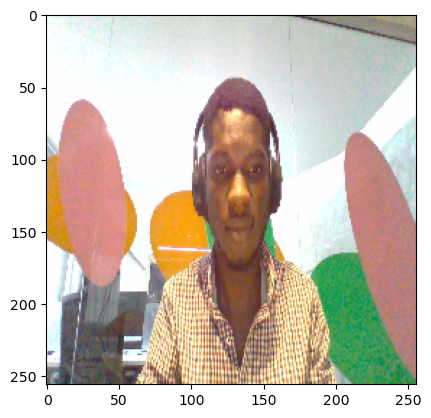

In [50]:
resize = tf.image.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [51]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 51ms/step


In [52]:
yhat

array([[0.9999683]], dtype=float32)

In [53]:
if yhat > 0.5: 
    print(f'Predicted class is male')
else:
    print(f'Predicted class is female')

Predicted class is male


## Save Model

In [54]:
from tensorflow.keras.models import load_model

In [55]:
model.save(os.path.join('models','imageclassifier.h5'))

In [57]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 193ms/step


array([[0.9999683]], dtype=float32)